In [15]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.image as mpimg
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv1D, LeakyReLU, AveragePooling1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.signal import butter, filtfilt
from kymatio.numpy import Scattering1D
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# ===================== CONFIG ======================
BASE_DIR = os.path.dirname(__file__)  # thư mục chứa file .py hiện tại
DATA_DIR = os.path.join(BASE_DIR, "training_data")
CSV_PATH = os.path.join(BASE_DIR, "training_data.csv")
MODEL_PATH = os.path.join(BASE_DIR, "models", "best_model.keras")
MAX_LEN = 3000
SR = 4000
J = 6

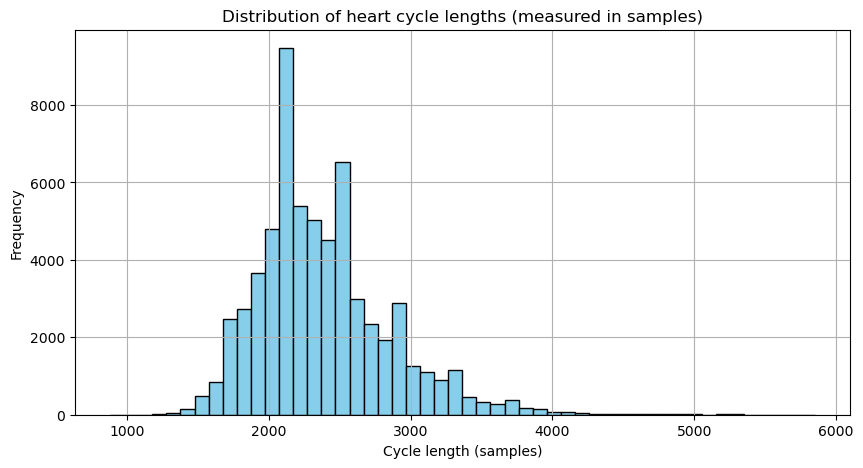

Number of heart cycles: 62777
Mean length: 2375.706516717906
Median length: 2319.0
Most common (mode): [(2000, 3367), (2320, 2998), (2079, 2609), (2160, 2320), (2240, 2289)]
Min: 880 | Max: 5848


In [4]:
#ANALYZE HEART CYCLE DURATIONS

# Find the appropriate value for MAX_lEN
tsv_dir = r"D:\PHD\data2022\training_data" 
SR = 4000  # Sampling rate (Hz)
cycle_lengths = []

for filename in os.listdir(tsv_dir):
    if filename.endswith(".tsv"):
        filepath = os.path.join(tsv_dir, filename)
        
        df = pd.read_csv(filepath, sep="\t", header=None, names=["start", "end", "label"])

        # Find all sequences of 4 consecutive labels: 1 → 2 → 3 → 4 (or 0 → 1 → 2 → 3 → 4 if there is a beat labeled 0).
        for i in range(len(df) - 3):
            labels = df.iloc[i:i+4]["label"].tolist()
            if labels == [1, 2, 3, 4]:
                start = df.iloc[i]["start"]
                end = df.iloc[i+3]["end"]
                duration_sec = end - start
                length_samples = int(duration_sec * SR)
                if 200 < length_samples < 6000:
                    cycle_lengths.append(length_samples)

# === HISTOGRAM ===
plt.figure(figsize=(10, 5))
plt.hist(cycle_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of heart cycle lengths (measured in samples)")
plt.xlabel("Cycle length (samples)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === STATISTICS===
print("Number of heart cycles:", len(cycle_lengths))
if cycle_lengths:
    print("Mean length:", np.mean(cycle_lengths))
    print("Median length:", np.median(cycle_lengths))
    print("Most common (mode):", Counter(cycle_lengths).most_common(5))
    print("Min:", np.min(cycle_lengths), "| Max:", np.max(cycle_lengths))
else:
    print("No valid cycles found.")


In [3]:
# ===================== HELPERS =====================
def butter_lowpass_filter(data, cutoff, sr, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalize_signal(sig):
    sig = sig - np.mean(sig)
    std = np.std(sig)
    return sig / std if std > 0 else sig  # Avoid division by zero

def extract_cycles(wav_path, tsv_path):
    try:
        signal, _ = librosa.load(wav_path, sr=SR)
        # Apply Butterworth low-pass filter
        signal = butter_lowpass_filter(signal, cutoff=500, sr=SR, order=5)
        df_seg = pd.read_csv(tsv_path, sep='\t', header=None, names=['start', 'end', 'label'])

        cycles = []
        for i in range(len(df_seg) - 3):
            labels_seq = df_seg.iloc[i:i+4]['label'].tolist()
            if labels_seq == [1, 2, 3, 4]:
                start = int(df_seg.iloc[i]['start'] * SR)
                end = int(df_seg.iloc[i+3]['end'] * SR)
                cycle = signal[start:end]
                if len(cycle) > 100:  # Exclude segments that are too brief
                    cycle = normalize_signal(cycle)
                    cycles.append(cycle)
        return cycles
    except:
        return []

def extract_scattering_features(signal):
    if len(signal) < MAX_LEN:
        # Apply padding if the signal segment is shorter than MAX_LEN
        signal = np.pad(signal, (0, MAX_LEN - len(signal)))
    else:
        signal = signal[:MAX_LEN]  # Cut off excess if the length is greater than MAX_LEN
    features = scattering(signal)
    return features


def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  
        Conv1D(128, kernel_size=3, padding='same'),
        LeakyReLU(),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
    
        Conv1D(64, kernel_size=3, padding='same'),
        LeakyReLU(),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
    
        Flatten(),
        Dense(128),
        Dropout(0.3),
        LeakyReLU(),
    
        Dense(64),
        Dropout(0.3),
        LeakyReLU(),
    
        Dense(32),
        ReLU(),
    
        Dense(3, activation='softmax')  # 3 output classes: Absent, Present, Unknown
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# CONVERT HEART SOUND RECORDINGS (WAV FILES) INTO SPECTROGRAM IMAGES
def save_spectrogram(wav_path, save_path):
    y, sr = librosa.load(wav_path, sr=4000)
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(abs(S), ref=np.max)

    fig, ax = plt.subplots(figsize=(6, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.axis('off')
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

BASE_DIR = os.path.dirname(__file__)

root_dir = os.path.join(BASE_DIR, "training_data")
csv_path = os.path.join(BASE_DIR, "training_data.csv")
save_dir = os.path.join(BASE_DIR, "spectrograms")


df = pd.read_csv(csv_path)
df['Murmur'] = df['Murmur'].astype(str).str.strip().str.capitalize()

# Create folders based on murmur labels 
murmur_categories = ['Absent', 'Present', 'Unknown']
for category in murmur_categories:
    os.makedirs(os.path.join(save_dir, category.lower()), exist_ok=True)

# Retrieve all .wav files from the folder
all_wav_files = os.listdir(root_dir)

for idx, row in df.iterrows():
    patient_id = str(row['Patient ID'])
    murmur = row['Murmur']

    if murmur not in murmur_categories:
        print(f"Skipped {patient_id} - invalid murmur label: {murmur}")
        continue

    # Find all .wav files that start with patient_id_
    matched_files = [f for f in all_wav_files if f.startswith(f"{patient_id}_") and f.endswith('.wav')]

    if not matched_files:
        print(f"Skipped {patient_id} - no matching .wav files found")
        continue

    for wav_file in matched_files:
        wav_path = os.path.join(root_dir, wav_file)
        output_folder = os.path.join(save_dir, murmur.lower())
        out_path = os.path.join(output_folder, wav_file.replace('.wav', '.png'))

        try:
            save_spectrogram(wav_path, out_path)
        except MemoryError:
            print(f"MemoryError when processing {wav_file}")
        gc.collect()


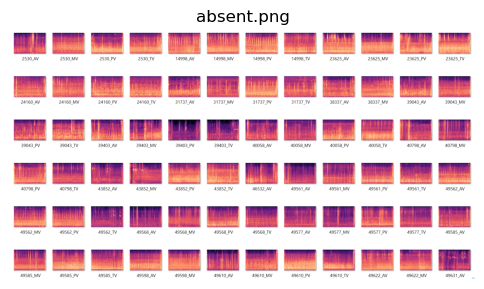

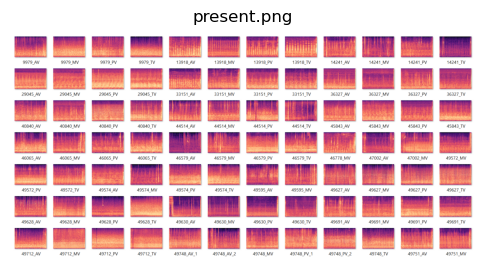

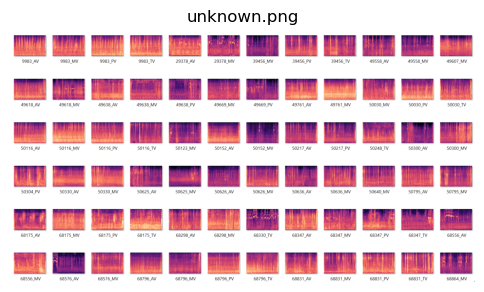

In [11]:
#Spectrogram: Absent, Present, Unknown category 
image_dir = r"D:\PHD\data2022\images"
png_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')]

for img_file in png_files:
    image_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(image_path)
    
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(img_file, fontsize=12)  
    plt.axis('off')
    plt.show()


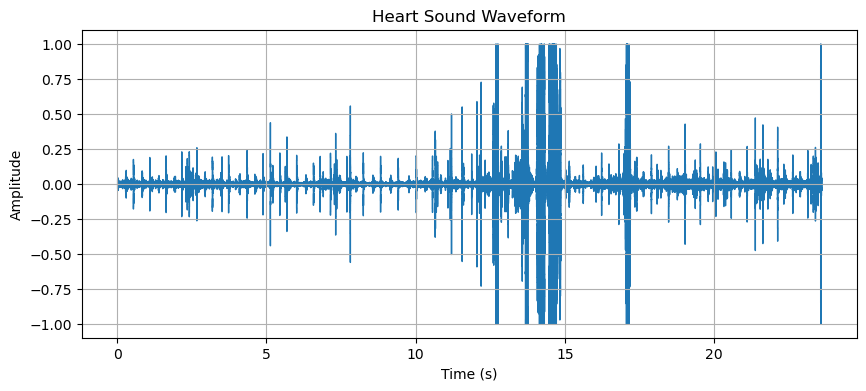

In [16]:
def plot_wav_waveform(wav_path, sr=None, figsize=(10, 4), title="Waveform"):
    y, sr = librosa.load(wav_path, sr=sr)
    plt.figure(figsize=figsize)
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

plot_wav_waveform(r"D:\PHD\data2022\training_data\2530_AV.wav", sr=4000, title="Heart Sound Waveform")



In [4]:
# ===================== LOAD LABELS =====================
df_info = pd.read_csv(CSV_PATH)
# Create a dictionary: patient_id → label
label_dict = {}
for _, row in df_info.iterrows():
    if row["Murmur"] == "Absent":
        label_dict[str(row["Patient ID"])] = 2
    elif row["Murmur"] == "Present":
        label_dict[str(row["Patient ID"])] = 1
    else:
        label_dict[str(row["Patient ID"])] = 0

In [6]:
# ===================== LOAD DATA and FEATURE EXTRACTION=====================
scattering = Scattering1D(J=6, shape=MAX_LEN)
X = []
y = []
for fname in os.listdir(DATA_DIR):
    if fname.endswith(".wav"):
        patient_id = fname.split("_")[0]
        valve = fname.split("_")[1].split(".")[0]
        tsv_name = f"{patient_id}_{valve}.tsv"
        wav_path = os.path.join(DATA_DIR, fname)
        tsv_path = os.path.join(DATA_DIR, tsv_name)

        if not os.path.exists(tsv_path):
            continue
        if patient_id not in label_dict:
            continue

        label = label_dict[patient_id]
        cycles = extract_cycles(wav_path, tsv_path)

        for cycle in cycles:
            features = extract_scattering_features(cycle)
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Total samples:  {len(y)} | Absent: {np.sum(y==2)} | Present: {np.sum(y==1)} | Unknown: {np.sum(y==0)}")

Total samples:  62021 | Absent: 47606 | Present: 12814 | Unknown: 1601


In [7]:
# Save to a file .npz
np.savez(r"D:\PHD\data2022\scattering_features_v02.npz", X=X, y=y)

# data = np.load(r"D:\PHD\data2022\scattering_features_v02.npz")
# X = data["X"]
# y = data["y"]


In [8]:
# ===================== BALANCE TRAIN SET =====================
# Filter indices by label
idx_present = np.where(y == 1)[0]
idx_absent = np.where(y == 2)[0]
idx_unknown = np.where(y == 0)[0]

# Number of samples in the Present class
n_present = len(idx_present)

# Downsample the Absent class to the same size as the Present class using random sampling
np.random.seed(42)
idx_absent_reduced = np.random.choice(idx_absent, size=n_present, replace=False)

# Keep all samples in the Unknown class
idx_final = np.concatenate([idx_present, idx_absent_reduced, idx_unknown])

# Randomly shuffle the indices to prevent bias
idx_final = shuffle(idx_final, random_state=42)

# Extract the balanced dataset
X_balanced = X[idx_final]
y_balanced = y[idx_final]

print(f"Number of samples after balancing: {len(y_balanced)}")
print(f"Absent: {np.sum(y_balanced == 2)} | Present: {np.sum(y_balanced == 1)} | Unknown: {np.sum(y_balanced == 0)}")


Number of samples after balancing: 27229
Absent: 12814 | Present: 12814 | Unknown: 1601


In [10]:
# ========SPLIT TRAIN/TEST =========
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

In [17]:
# ===================== TRAINING WITH CV =====================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n===== Fold {fold} =====")
    model = build_model(X_train.shape[1:])
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=15, batch_size=32,
        verbose=0
    )
    _, acc = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)
    fold_acc.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")

print("\nCV Accuracies:", fold_acc)
print(f"Mean: {np.mean(fold_acc):.4f}, Std: {np.std(fold_acc):.4f}")


===== Fold 1 =====
Validation Accuracy: 0.7569

===== Fold 2 =====
Validation Accuracy: 0.7537

===== Fold 3 =====
Validation Accuracy: 0.7668

===== Fold 4 =====
Validation Accuracy: 0.7691

===== Fold 5 =====
Validation Accuracy: 0.7564

CV Accuracies: [0.756942868232727, 0.7537296414375305, 0.7668120265007019, 0.7690541744232178, 0.7564279437065125]
Mean: 0.7606, Std: 0.0061


Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6301 - loss: 0.7994 - val_accuracy: 0.7058 - val_loss: 0.6679
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7080 - loss: 0.6699 - val_accuracy: 0.7066 - val_loss: 0.6467
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7268 - loss: 0.6291 - val_accuracy: 0.7066 - val_loss: 0.6244
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7444 - loss: 0.6032 - val_accuracy: 0.7334 - val_loss: 0.6056
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7459 - loss: 0.5859 - val_accuracy: 0.7431 - val_loss: 0.5849
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7472 - loss: 0.5838 - val_accuracy: 0.7427 - val_loss: 0.5867
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7607 - loss: 0.5507 - val_accuracy: 0.7429 - val_loss: 0.5849
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7630 - loss: 0.5475 - val_accuracy: 0.

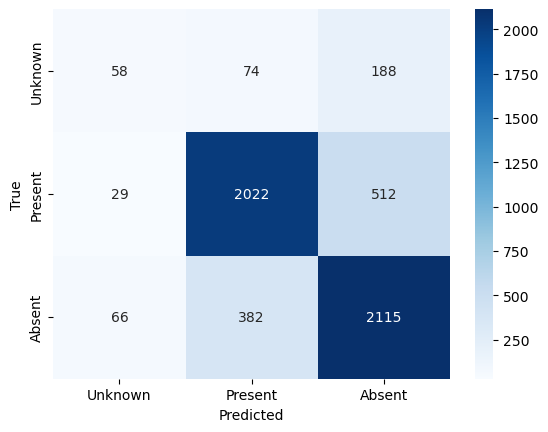


Classification Report:
              precision    recall  f1-score   support

     Unknown       0.38      0.18      0.25       320
     Present       0.82      0.79      0.80      2563
      Absent       0.75      0.83      0.79      2563

    accuracy                           0.77      5446
   macro avg       0.65      0.60      0.61      5446
weighted avg       0.76      0.77      0.76      5446

Test Accuracy: 0.7702901211898642


In [18]:
# ===================== FINAL TRAIN & TEST =====================
model = build_model(X_train.shape[1:])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)
]
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32,
          callbacks=callbacks, verbose=1)

model = load_model(MODEL_PATH)

# ===================== EVALUATION =====================
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unknown', 'Present', 'Absent'],
            yticklabels=['Unknown', 'Present', 'Absent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Unknown', 'Present', 'Absent']))
print("Test Accuracy:", accuracy_score(y_test, y_pred))